In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
from phantom_functions import create_ptycho_phantom, calculate_wavelength, read_probe_positions_new, convert_positions_to_pixels,set_object_size_pxls, load_data
from ptycho_functions import RAAR_loop, mPIE_loop,RAAR_multiprobe_loop,PIE_multiprobe_loop, plot_results3, plot_probe_modes, get_simulated_data, plot_guess_and_model

/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscCdi-0.4.0-py3.6-linux-ppc64le.egg/sscCdi
to be done!
/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscRaft/lib/libraft.cpython-36m-powerpc64le-linux-gnu.so


## Phantom

In [2]:
inputs = {
"path" : "/home/ABTLUS/yuri.tonin/00000000/data/ptycho3d/complex_phantom/",
"matrix_size": 128, # n of pixels; one side of cube
"n_cpus": 100, # cpu cores
"energy": 6, #keV
"distance": 1, # meter
"detector_pixel": 8*1.25156e-6,
"probe_steps_xy": [25,20], # pixels
"n_of_angles": 0
}

# phantom, magnitude, phase, sinogram, probe, data = create_ptycho_phantom(inputs,sample="donut",probe_type="CAT",position_errors=False,load=True,preview=False)

## Ptycho

Object pixel size: 2.1962328634132057e-08
Oversampling:  2.6987309425621477
[[  0   0]
 [ 20   0]
 [ 40   0]
 [ 60   0]
 [ 80   0]
 [100   0]
 [  0  25]
 [ 20  25]
 [ 40  25]
 [ 60  25]
 [ 80  25]
 [100  25]
 [  0  50]
 [ 20  50]
 [ 40  50]
 [ 60  50]
 [ 80  50]
 [100  50]
 [  0  75]
 [ 20  75]
 [ 40  75]
 [ 60  75]
 [ 80  75]
 [100  75]
 [  0 100]
 [ 20 100]
 [ 40 100]
 [ 60 100]
 [ 80 100]
 [100 100]]


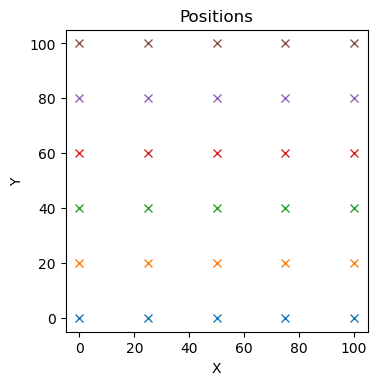

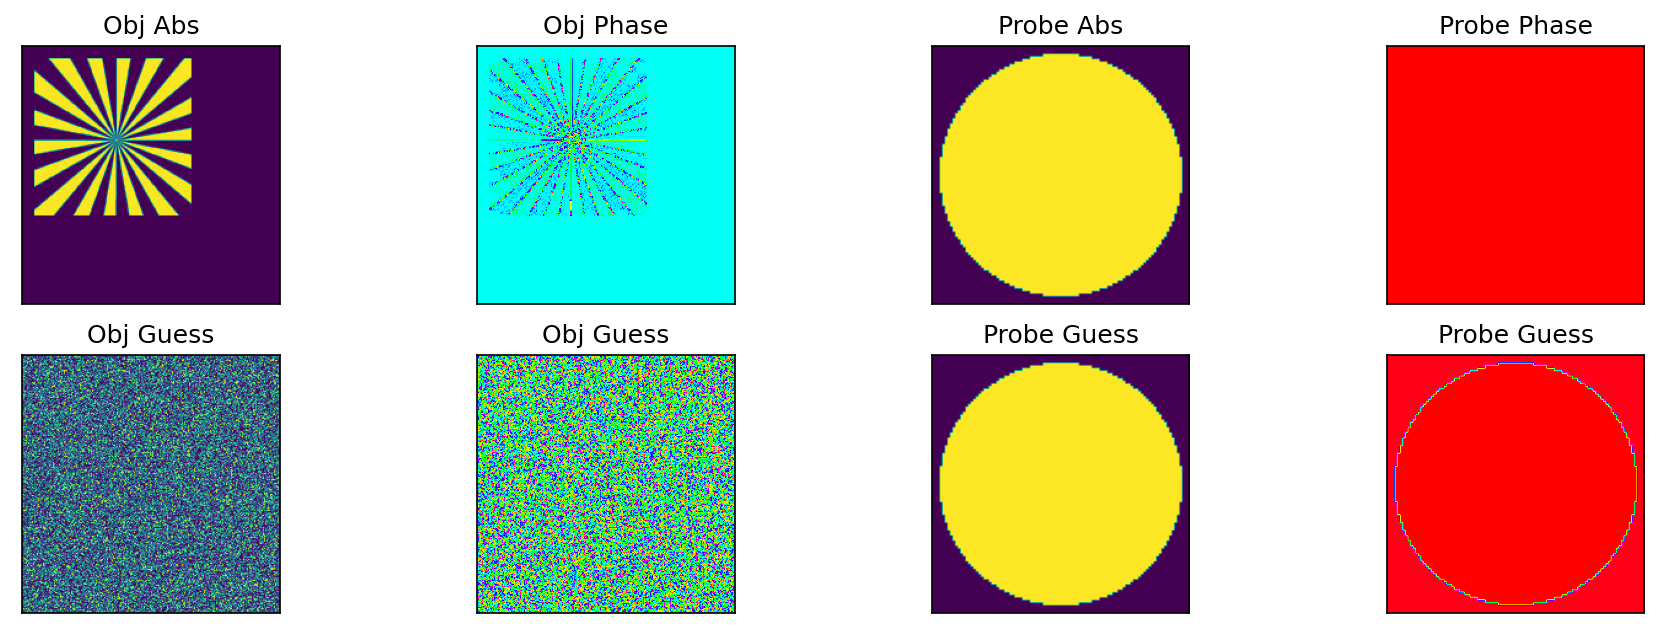

In [3]:
if 1: # dummy sample
    diffraction_patterns, positions, model_obj, model_probe, positions_errors = get_simulated_data(inputs["probe_steps_xy"],random_positions=False,add_position_errors=False)

    """ Experiment Parameters """
    c_speed = 299792458        # Velocity of Light [m/s]
    planck  = 4.135667662E-18  # Plank constant [keV*s]
    position_step = np.max([positions[i]-positions[i-1] for i in range(1,len(positions))])*1e-6
    distance = 30  # meters
    energy = 10    # keV
    n_pixels = 3072
    pixel_size = 55.13e-6  # meters
    wavelength = c_speed * planck / energy
    dx = wavelength*distance/(n_pixels*pixel_size)
    oversampling_ratio = wavelength*distance/(position_step*pixel_size)
    print('Object pixel size:',dx)
    print("Oversampling: ",oversampling_ratio)
    experiment_params = dx, wavelength,distance
    probe_guess = model_probe*np.exp(-1j*model_probe*2)
    obj_guess = np.ones_like(model_obj) # constant object
    obj_guess = np.random.rand(model_obj.shape[0],model_obj.shape[1])+1j
    
    
else: # complex phantom
    data_folder = "/home/ABTLUS/yuri.tonin/00000000/data/ptycho3d/"
    dataname = "complex_phantom"
        
    diffraction_patterns, positions, model_obj, model_probe, obj_pixel_size, wavelength,distance = load_data(data_folder,dataname)
    experiment_params = obj_pixel_size, wavelength,distance
    
    """ Initial guesses """
    object_offset = 10
    Y_pxls, X_pxls = convert_positions_to_pixels(obj_pixel_size,positions,object_offset)
    object_shape = set_object_size_pxls(X_pxls,Y_pxls,probe.shape,object_offset)
    obj_guess = np.random.rand(object_shape[0],object_shape[1])+1j
    # probe_guess = model_probe*np.exp(-1j*model_probe*2)
    probe_guess = model_probe
    
iterations = 100
n_of_modes = 1

# shapey,shapex = probe.shape
# for index, pos in enumerate((positions)):
#     posy, posx = pos[1], pos[0]
#     print(obj_guess.shape,obj_guess[posy:posy + shapey , posx:posx+ shapex].shape,posy,posy + shapey , posx,posx+ shapex)

    
print(positions)
plot_guess_and_model(model_obj,model_probe,obj_guess,probe_guess)

In [4]:
if 1: 
    """ RAAR """
    beta = 0.995
    epsilon = 0.01
    RAAR_params = (beta,epsilon)
    RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj)
    
if 1: 
    """ mPIE """
    if 0: # suggested min from paper
        regularization_object, regularization_probe = 0.05, 0.5
        step_object, step_probe = 0.1, 0.2
        friction_object, friction_probe = 0.5, 0.75
        momentum_counter = 10
    else: # suggested max from paper
        regularization_object, regularization_probe = 0.25, 5
        step_object, step_probe = 0.5, 1
        friction_object, friction_probe = 0.9, 0.99
        momentum_counter = 100 

    mPIE_params = (regularization_object,regularization_probe,step_object,step_probe,friction_object,friction_probe,momentum_counter)
    PIE_obj, PIE_probe, PIE_error, PIE_time = mPIE_loop(diffraction_patterns, positions,obj_guess.copy(),probe_guess, mPIE_params, experiment_params, iterations, model_obj)
    
if 1: 
    """ multiprobe RAAR """
    beta = 0.995
    epsilon = 0.01
    RAAR_params = (beta,epsilon)
    RAAR2_obj, RAAR2_probes, RAAR2_error, RAAR2_time = RAAR_multiprobe_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj,n_of_modes=n_of_modes)
    RAAR2_probe = RAAR2_probes[0]
    
if 1: 
    """ multiprobe mPIE """
    mPIE_params = {}
    mPIE_params["regularization_object"] = regularization_object
    mPIE_params["regularization_probe"]  = regularization_probe
    mPIE_params["step_object"]           = step_object
    mPIE_params["step_probe"]            = step_probe
    mPIE_params["friction_object"]       = friction_object
    mPIE_params["friction_probe"]        = friction_probe
    mPIE_params["momentum_counter"]      = momentum_counter
    PIE2_obj, PIE2_multiprobe, PIE2_error, PIE2_time  = PIE_multiprobe_loop(diffraction_patterns, positions, iterations, mPIE_params, model_obj,n_of_modes = n_of_modes, object_guess=obj_guess.copy(), probe_guess=probe_guess, use_momentum = True)
    PIE2_obj = PIE2_obj[0]
    PIE2_probe = PIE2_multiprobe[0]


Starting RAAR...
	Iteration 0/100
	Iteration 50/100


Starting PIE...
	Iteration 0/100
	Iteration 50/100


Starting multiprobe RAAR...
	Iteration 0/100
	Iteration 50/100
RAAR algorithm ended in 4.615520254010335 seconds


Starting multiprobe PIE algorithm...
	Iteration 0/100
	Iteration 50/100
PIE algorithm ended in 6.244142754934728 seconds


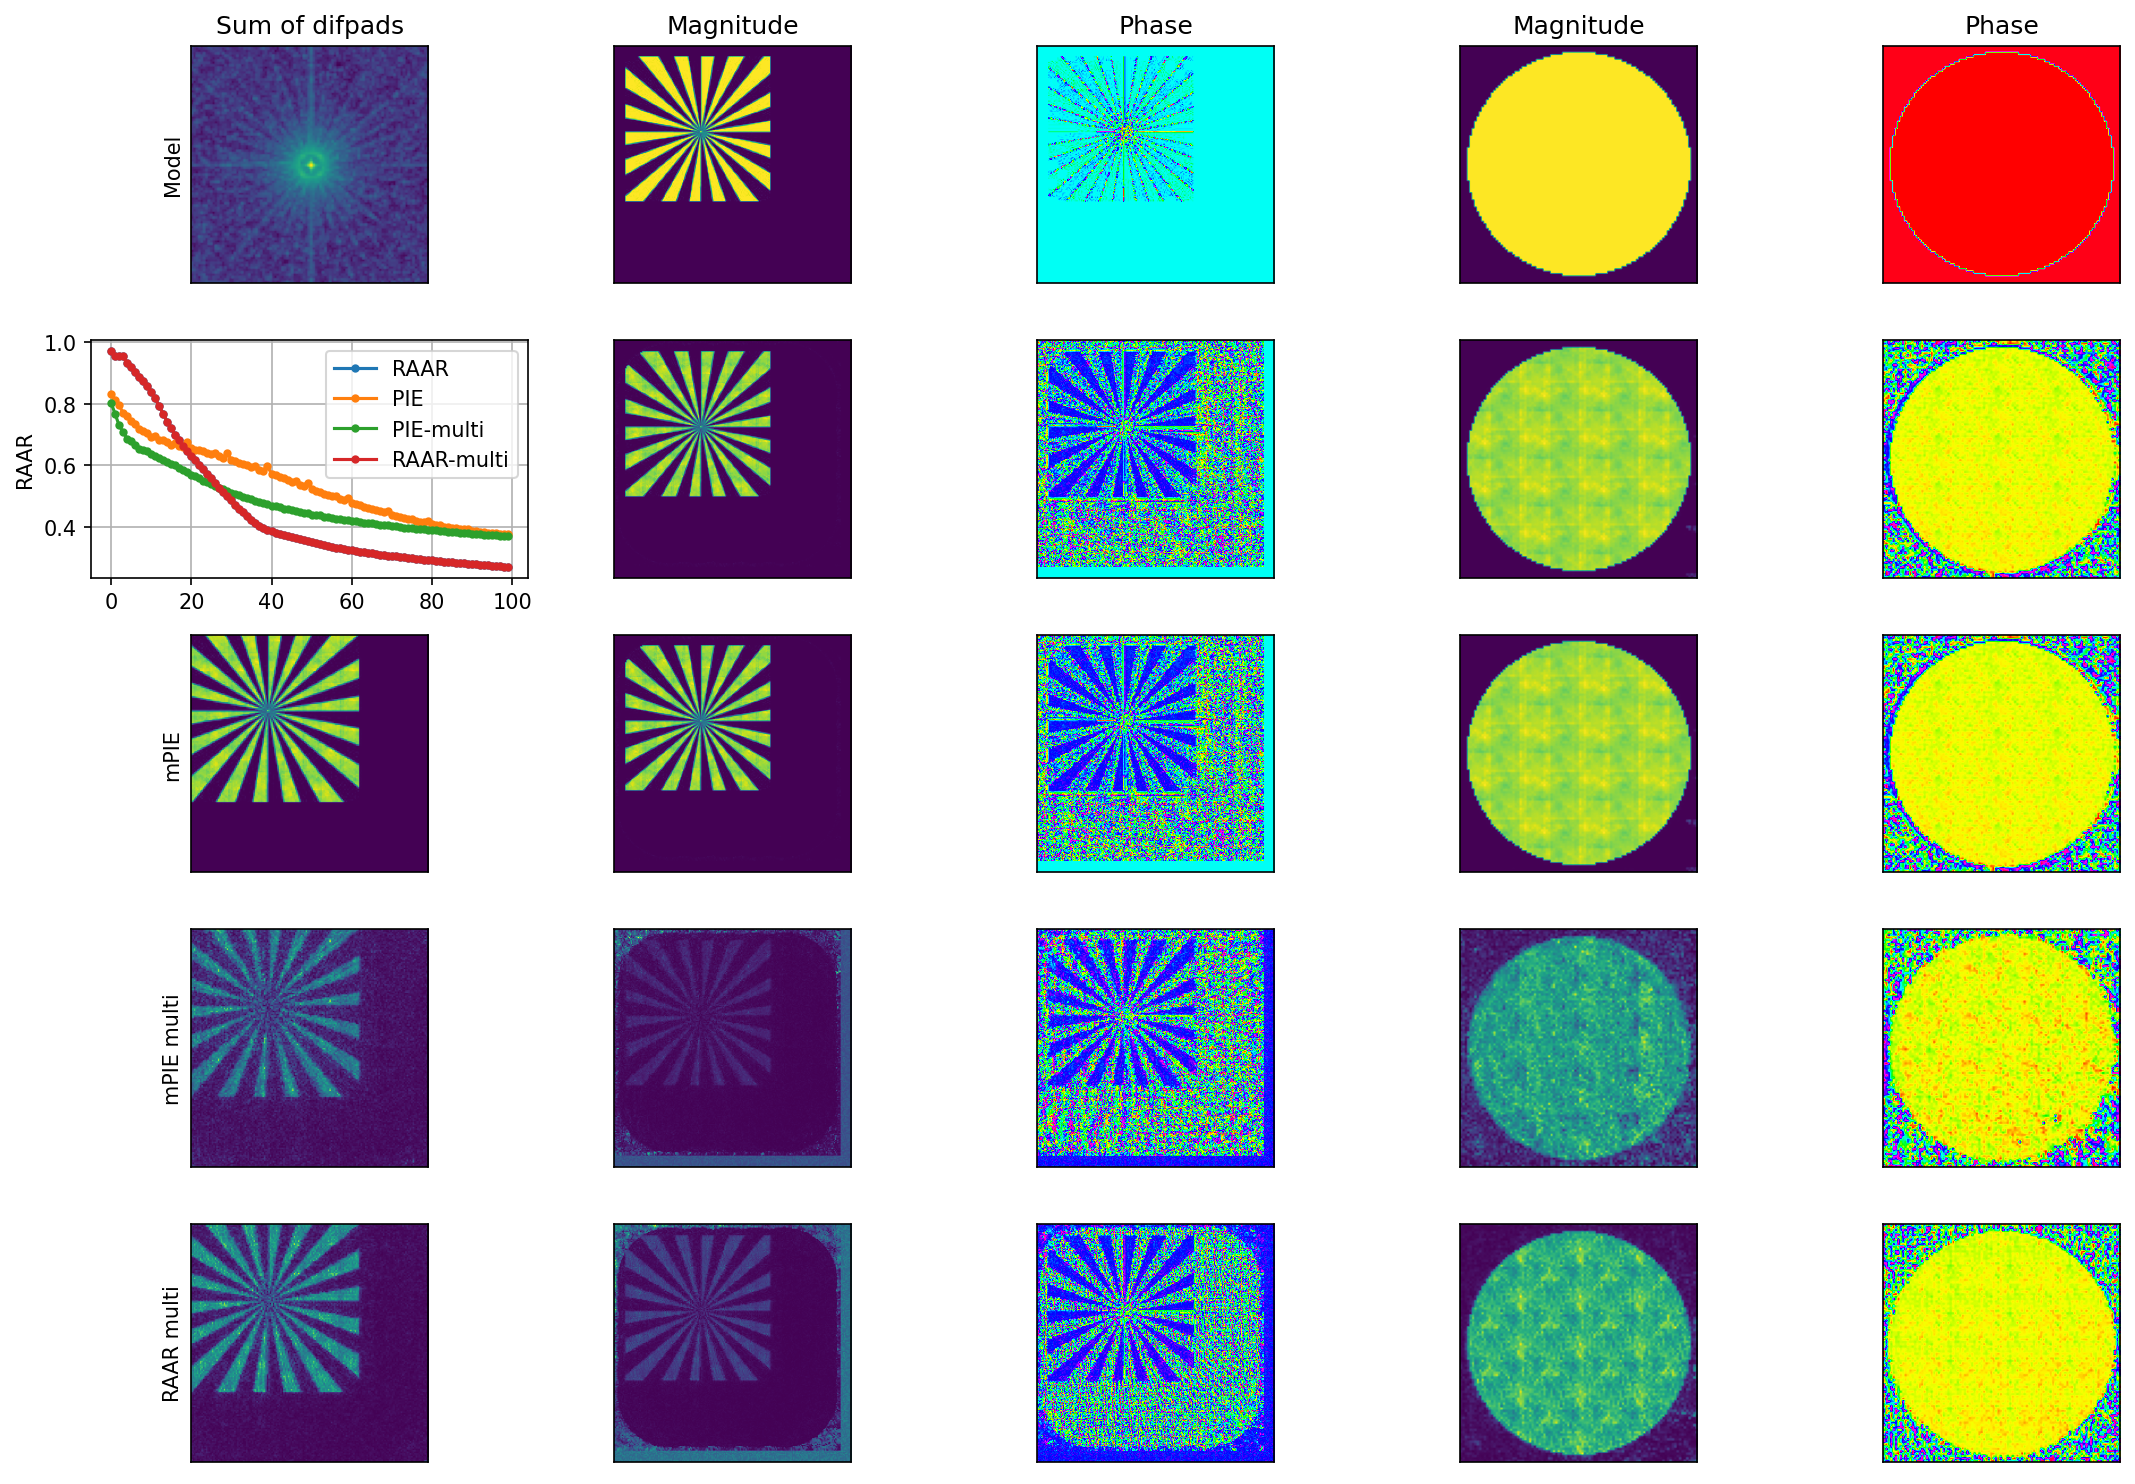

In [5]:
if 1:
    # PIE_obj, PIE_probe, PIE_error, PIE_time = RAAR_obj, RAAR_probe, RAAR_error, RAAR_time
    # PIE2_obj, PIE2_probe, PIE2_error, PIE2_time = RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,
    # RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time = RAAR_obj, RAAR_probe, RAAR_error, RAAR_time

    plot_results3(diffraction_patterns,model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time )
    # plot_probe_modes(PIE2_multiprobe)
    # plot_probe_modes(RAAR2_probes)